@ This notebook was written by The Cuong

<center> 
    <h2>PHÂN LOẠI UNG THƯ TRONG BÀI TOÁN DỰ ĐOÁN UNG THƯ SỬ DỤNG CÁC THUẬT TOÁN PHÂN CỤM<h2>
<center>

Trước tiên, ta import các thư viện cần thiết

In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cv2
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score

Thực hiện việc tải dữ liệu. Dữ liệu gồm 28 ảnh ung thư miệng từ trang web

In [2]:
folder_path = "Data\Testing Data set"
images = []
for filename in os.listdir(folder_path):
    if filename.endswith('.webp') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        image = image.reshape(-1)
        images.append(image)

Chúng ta sẽ xem tất cả các ảnh

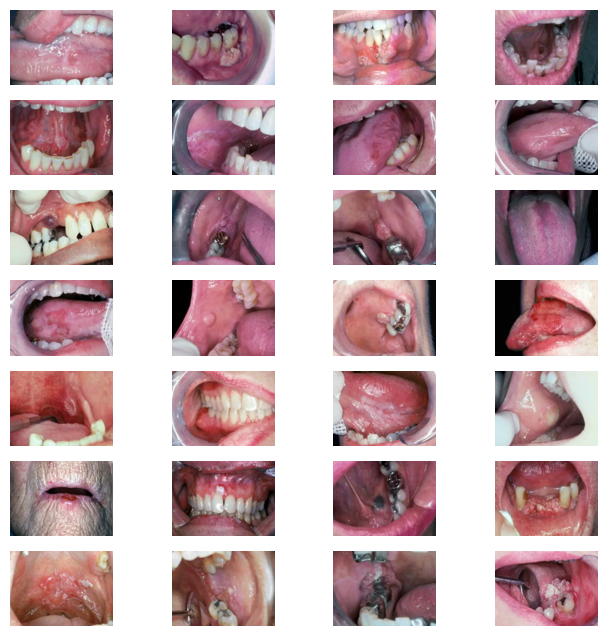

In [3]:
fig, axs = plt.subplots(7,4, figsize=(8, 8))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        axs[j, i].imshow(image)
        axs[j, i].axis("off")
fig.savefig('images.png')
plt.show()

Ngay từ đầu, bài toán của chúng em là "Chuẩn đoán ung thư miệng với bộ dữ liệu do thầy cung cấp". Bộ dữ liệu này gồm 30 ảnh

Để thực hiện mục tiêu áp dụng kỹ thuật phân cụm vào mô hình học máy. Chúng em sẽ phân cụm dựa trên ảnh, sau đấy chúng em chọn ra số lượng cụm tối ưu nhất cho các ảnh, và sử dụng các cụm đó để có thể phân đoạn được ảnh. Với mỗi kỹ thuật phân cụm, đều có những các ưu điểm khác nhau, áp dụng cho các mục đích khác nhau. Vì vậy các phương pháp đánh giá cũng sẽ khác nhau

Tiếp theo đây là phần đánh giá phân cụm dựa trên một ảnh với thuật toán KMeans

### Đánh giá phân cụm trên các ảnh với thuật toán KMeans

Đối với thuật toán KMeans, chúng ta có một tham số duy nhất, đó là n_clustering (số lượng cụm). Để chọn ra số lượng cụm tối ưu cho mỗi ảnh, chúng em sử dụng các phương pháp khác nhau như Enboil, Shilhouse, Visualize.

Chúng ta sẽ thực hiện phân đoạn trên tất cả ảnh

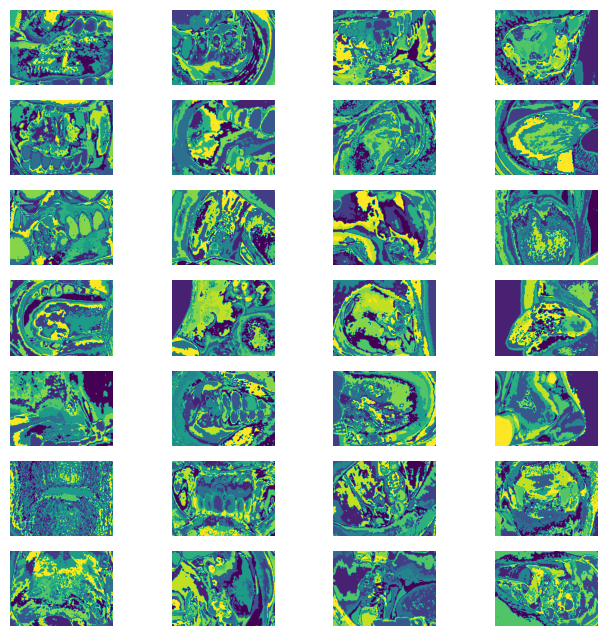

In [71]:
method = KMeans(n_clusters=5)
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(8, 8))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        axs[j, i].imshow(labels.reshape((205, 280)))
        axs[j, i].axis("off")
plt.savefig('image_segmentation.png')
plt.show()


#### Elbow cho tất cả các ảnh

Như đã nói ở trên, để chọn ra số cụm phù hợp cho bộ dữ liệu này, chúng ta sẽ sử dụng phương pháp Elbow. 

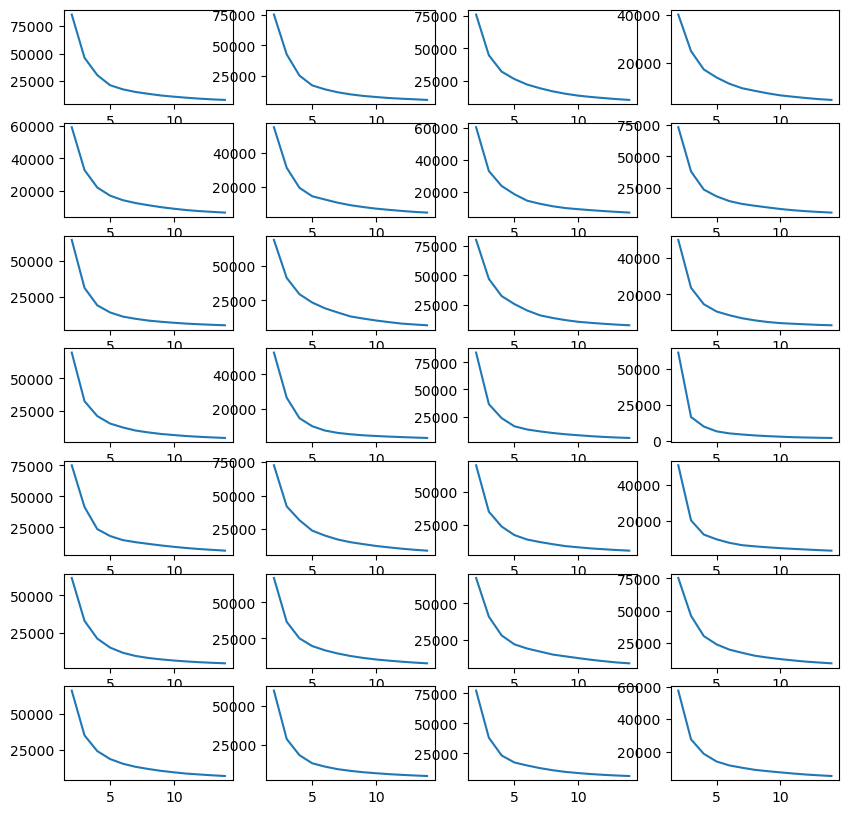

In [101]:
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(10, 10))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        sse = {}
        for k in range(2, 15):
            method = KMeans(n_clusters=k)
            method.fit(data)
            labels = method.labels_
            sse[k] = method.inertia_
        
        axs[j, i].plot(list(sse.keys()), list(sse.values()))
plt.savefig(f'image_segmentation_{k}.png')
plt.show()

Từ kết quả trên, chúng ta có thể thấy nhìn chung, các ảnh đều phân đoạn ra rõ ràng khi số cụm có thể là 5 hoặc 6

### Đánh giá phân cụm trên các ảnh với Hierarchical

Đối với phân cụm phân cấp, chúng ta cần chọn ra số lượng cụm so cho mức độ khác biêt của nó đủ phù hợp. Chúng ta sẽ sử dụng đồ thi Dendrogram cho việc này.

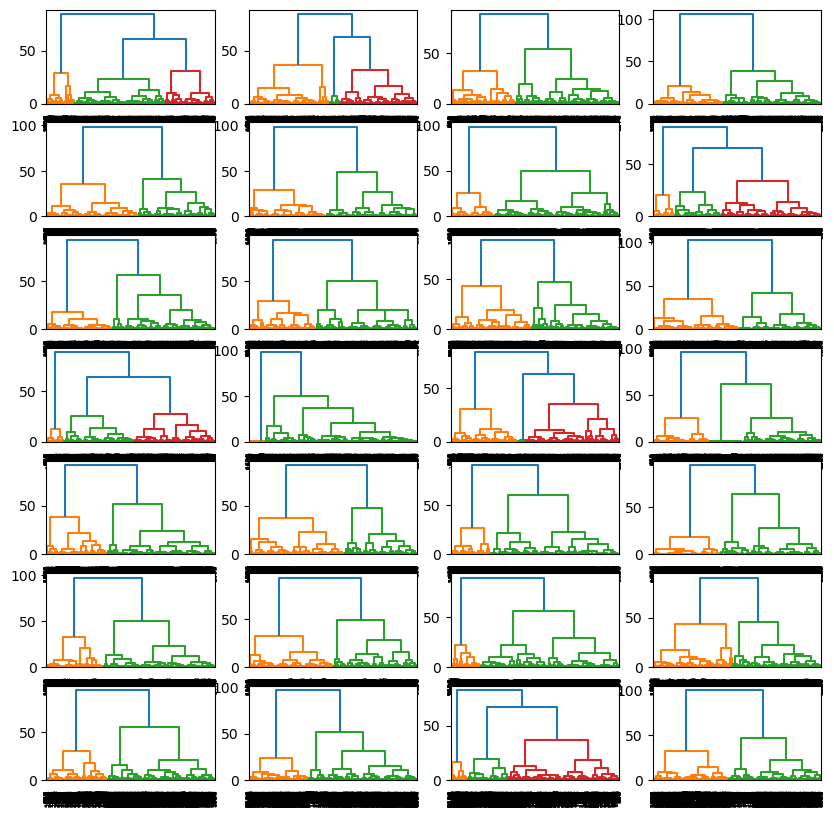

In [15]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(10, 10))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (50, 50))

        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        shc.dendrogram(shc.linkage(data, method='ward'), ax=axs[j,i])
plt.savefig('Hierarchy_dendrogram.png')
plt.show()

Từ các kết quả trên, ta có thể đánh giá rằng số lượng cụm tối ưu của phương pháp này là khoảng 3,4,5 cụm thì các kết quả cho các ảnh khá tốt. Tuy nhiên, với việc phải giảm kích thước ảnh để phân cụm làm một phần nào đó lượng thông tin đã bị mất mát đi. Thêm vào đó, thời gian chạy lâu cùng với yêu cầu xử lý lượng lớn điểm ảnh đồng thời khiên cho việc dùng phương pháp này để phân đoạn ảnh là chưa thực sự tối ưu.

Dưới đây là chúng em đã giản kích thước ảnh về 100 * 100, sau đó áp dụng phân cụm phân cấp để phân đoạn ảnh với số cụm là 5

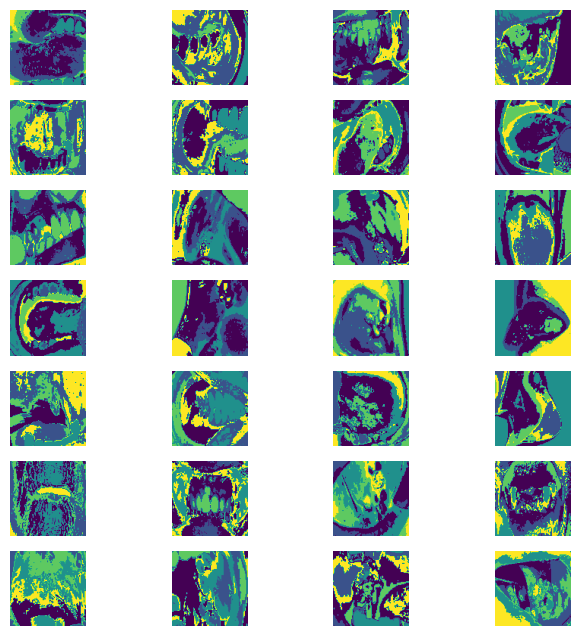

In [14]:
from sklearn.cluster import AgglomerativeClustering
method = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(10, 10))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (100, 100))
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        axs[j, i].imshow(labels.reshape((100, 100)))
        axs[j, i].axis("off")
plt.savefig('Agglomerative_image_segmentation.png')
plt.show()

### Đánh giá phân cụm trên các ảnh với thuật toán DBSCAN

Đối với thuật toán DBSCAN, chúng ta có hai tham số, eps (bán kính) và min_samples

Để tìm được eps tối ưu, chúng em sử dụng thuật toán KNN (hàng xóm gần nhất) việc này giúp ta chọn được eps chung cho toàn bộ dữ liệu ảnh.

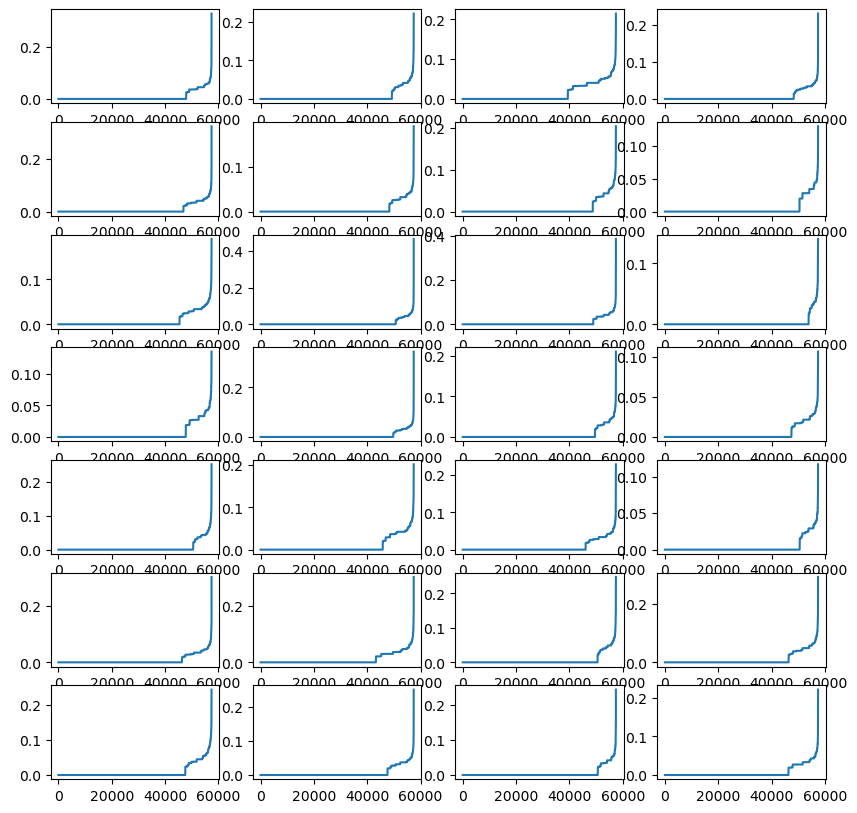

In [83]:
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(10, 10))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)
        
        neigh = NearestNeighbors(n_neighbors=5)
        nbrs = neigh.fit(data)
        distances, indices = nbrs.kneighbors(data)

        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        
        axs[j, i].plot(distances)
plt.savefig(f'image_KNN.png')
plt.show()

Nhận xét, ta thấy được khoảng eps hợp lý là khoảng 0.05. Vì vậy ta sẽ thử DBSCAN với eps = 0.05 và với min_sample = 5 để phân đoạn ảnh.

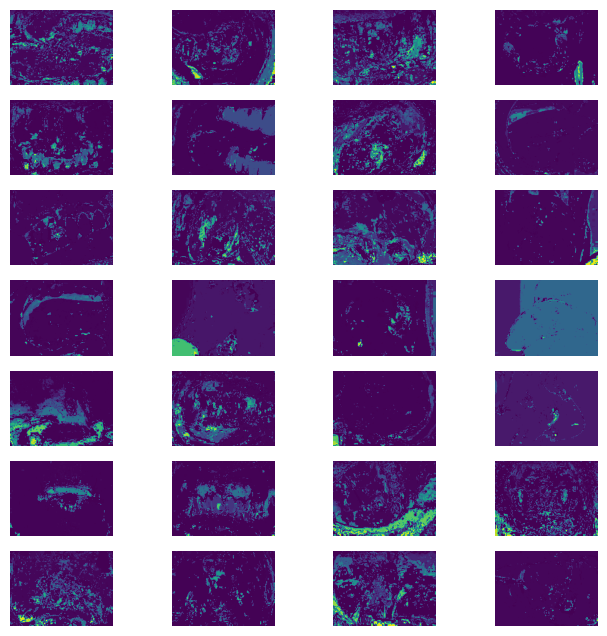

In [85]:
method = DBSCAN(eps = 0.05, min_samples=12)
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(8, 8))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        axs[j, i].imshow(labels.reshape((205, 280)))
        axs[j, i].axis("off")
plt.savefig('DBSCAN_image_segmentation.png')
plt.show()

#### Đánh giá phân cụm trên các ảnh với thuật toán STING

Chưa viết xong

### Đánh giá việc phân đoạn ảnh với các phương pháp KMeans, DBSCAN, Hierarchical.... bằng chỉ số Davies Bouldin

#### Đối với KMean

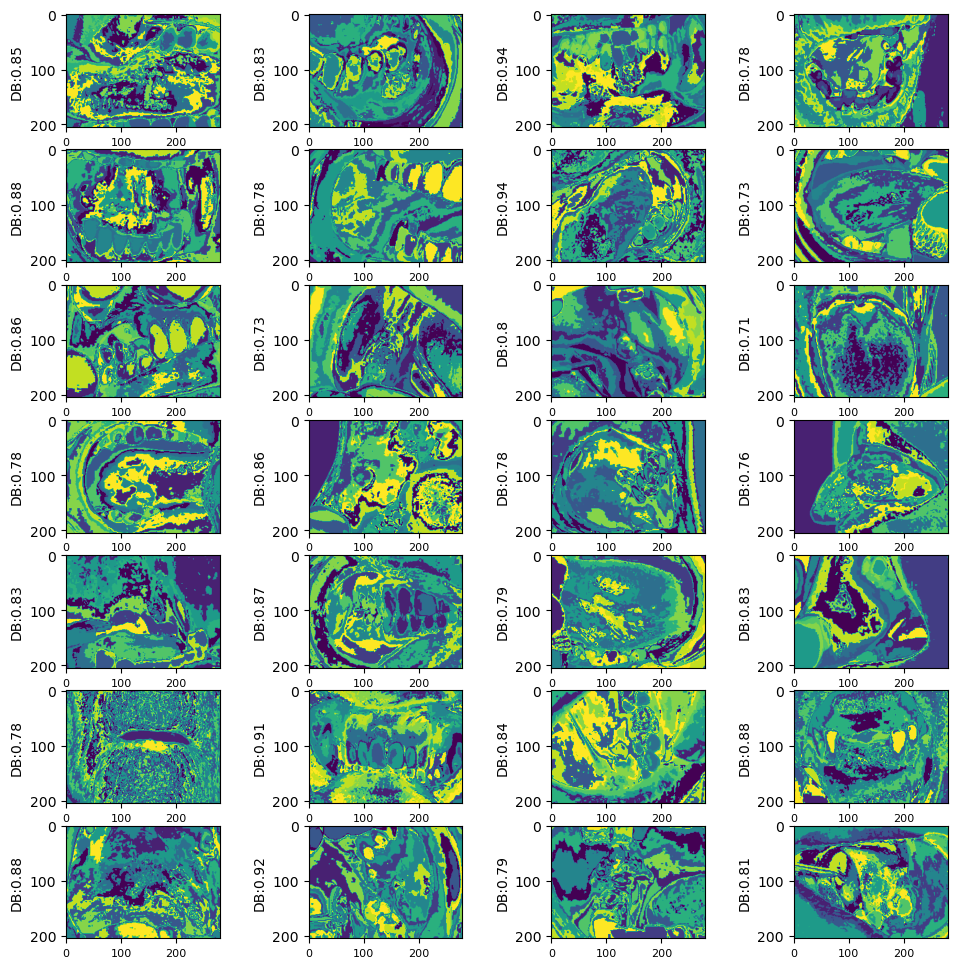

In [99]:
method = KMeans(n_clusters=12)
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(12, 12))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        db = davies_bouldin_score(data, labels=labels)
        db = round(db, 2)
        axs[j, i].imshow(labels.reshape((205, 280)))
        axs[j, i].tick_params(axis='x', labelsize=8)
        axs[j, i].set_ylabel(f"DB:{db}")
plt.savefig('image_segmentation_db.png')
plt.show()

Từ kết quả trên, chúng ta có thể thấy kết quả của DB cho phương pháp KMeans khá ổn, các cụm cách xa nhau và ít phân tán chồng chéo. Các ảnh đều cho chỉ số DB nằm trong ngưỡng có thể chấp nhận được, từ 0.79 đến 0.94

#### Đối với Hierarchical

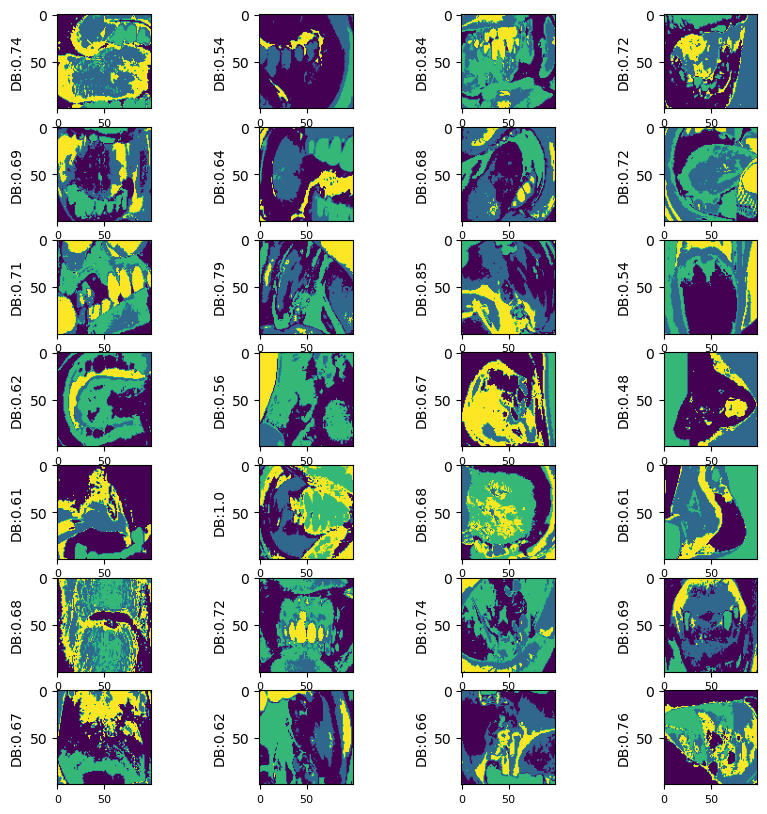

In [5]:
from sklearn.cluster import AgglomerativeClustering
method = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(10, 10))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        image = cv2.resize(image, (100, 100))
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        db = davies_bouldin_score(data, labels=labels)
        db = round(db, 2)

        axs[j, i].imshow(labels.reshape((100, 100)))
        axs[j, i].tick_params(axis='x', labelsize=8)
        axs[j, i].set_ylabel(f"DB:{db}")
plt.savefig('Agglomerative_image_segmentation_db.png')
plt.show()

Từ kết quả trên, chúng ta có thể thấy rằng...

#### Đối với DBSCAN

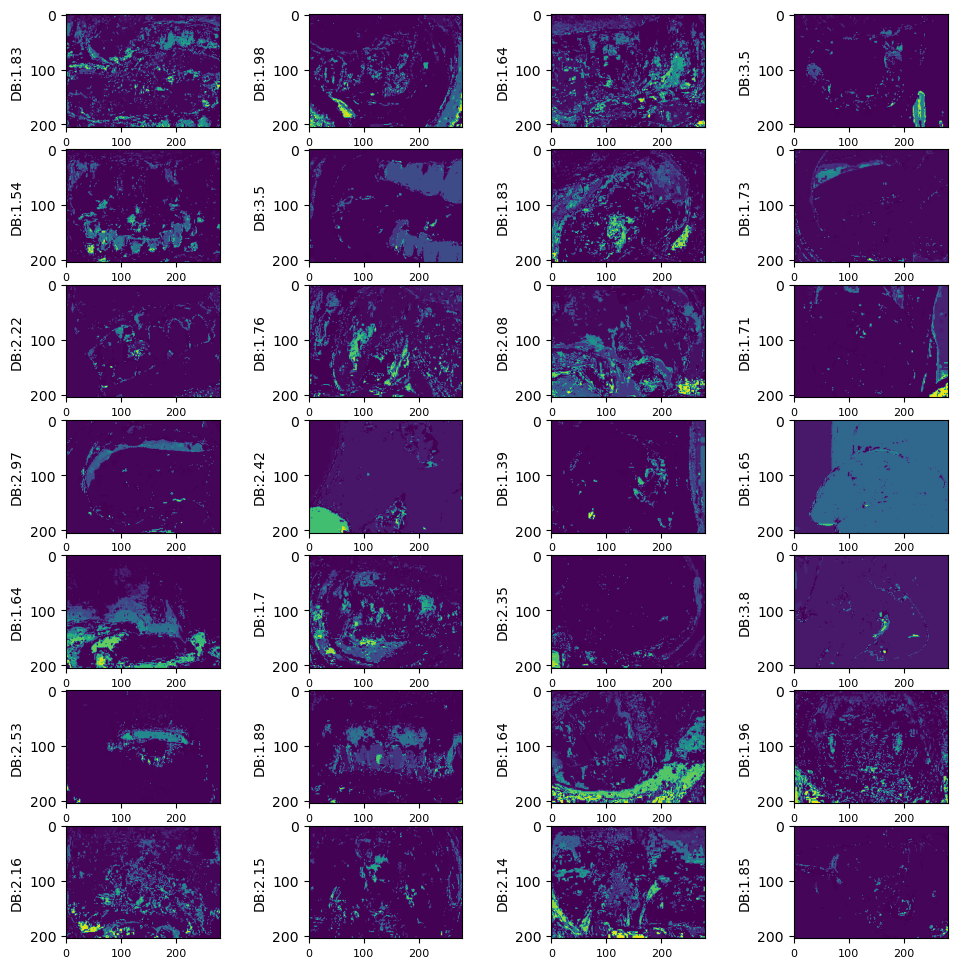

In [100]:
method = DBSCAN(eps = 0.05, min_samples=12)
scaler = StandardScaler()
fig , axs = plt.subplots(7,4,figsize=(12, 12))
for j in range(7):
    for i in range(4):
        image = images[j*4+i].reshape((205, 280, 3))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        
        data = image.reshape((-1, 3))
        data = scaler.fit_transform(data)

        method.fit(data)
        labels = method.labels_

        db = davies_bouldin_score(data, labels=labels)
        db = round(db, 2)

        axs[j, i].imshow(labels.reshape((205, 280)))
        axs[j, i].tick_params(axis='x', labelsize=8)
        axs[j, i].set_ylabel(f"DB:{db}")
plt.savefig('DBSCAN_image_segmentation_db.png')
plt.show()

Từ kết quả trên, chúng ta có thể thấy rằng DB của DBSCAN lớn hơn so với thuật toán KMeans, tuy nhiên nó lại không đồng đều giữa các ảnh, sự chênh lệch đôi khi lên tới gấp đôi. Vì vậy, DBSCAN chưa thực sự phù hợp với bộ dữ liệu ảnh này.

#### Đối với STING